In [1]:
import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve

# R -> The distance from the centre
# t -> The time
# D -> Diffusion coefficient
# E is the energy, no energy is lost in this system

## Define the following functions
dN/dE represents the distribution of energies, and can be calculated with the following formula. 

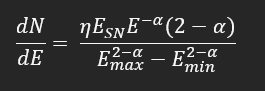

In [2]:
@u.quantity_input(E = u.erg)
def dNdE(E, Emax = 5*u.PeV, Emin=1*u.GeV, eta = 0.25, Esn = 1e52*u.erg, alpha = 1):
    dNdE = (eta*Esn*(-alpha+2))/(Emax**(2-alpha)-Emin**(2-alpha))*E**-alpha
    return dNdE

Rshell shows the radius of the shockfront of the supernova remenant. For this model, Rshell is where the where the particles are injected into the model. This results in the distribution function being 0 for R < Rshell.
The following formula is used to find Rshell.

![Rshell formula.png](<attachment:Rshell formula.png>)
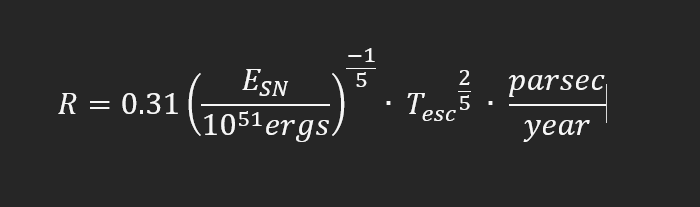

In [3]:
@u.quantity_input(t=u.yr, E=u.eV)
def Rshell(E, n0=10/u.cm**3, ESN=1e52*u.erg, Emax = 5*u.PeV, beta = 2.48):
    R = 0.31*(ESN/(1e51*u.erg))**(1/5)*(n0/(u.cm**-3))**(-1/5)*(Tesc(E, Emax, beta)/u.yr)**(2/5) *u.pc
    return R.to(u.pc)

Tesc represents the time taken for the average particle at a given energy to pass the shock front of the supernova remenant. Similar to Rshell, the distribution function is 0 for T < Tesc. This can be calculated using the following formula.

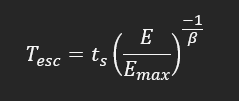

In [4]:
@u.quantity_input(E=u.erg)
def Tesc(E, Emax = 5*u.PeV, beta = 2.48, ts = 1600*u.yr):
    return (ts*(E/Emax)**(-1/beta)).to(u.yr)

The diffudsion coefficient dictates how fast the particles will diffuse through space. This can be calculated as follows.

![D(E).png](attachment:D(E).png)

In [5]:
@u.quantity_input(E=u.erg)
def diffusion(E, B = 50 * u.uG, x = 0.1, delta = 0.5, Dn = 3e27 * 0.1 ):
    dif = x * Dn * ((3*E/(u.GeV))/(10*B/(u.uG)))**delta
    return dif * u.cm**2 * u.s**-1

The distribution shows the spread of particles at any given radius greater than Rshell,any time greater then tesc and any energy. The function outputs in units of per energy per unit volume. Rdiff shows the radius of the sphere up to which the particles of energy E effectivly propogate to in time t. The distribution and Rdiff can be calculated with the following formulea.

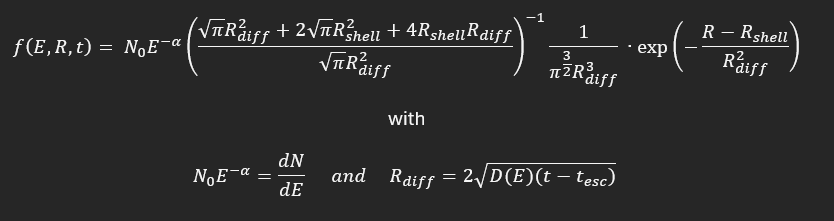

In [6]:
@u.quantity_input(E=u.erg, R=u.pc, t=u.yr)
def distribution(E, R, t, alpha = 2.7):
    Rdif = 2 * np.sqrt(diffusion(E) * (t - Tesc(E)))

    first1 = (np.pi**(1/2))*(Rdif**2) 
    first2 = 2*(np.pi**(1/2)*(Rshell(E))**2) 
    first3 = 4*Rshell(E)*(Rdif)
    
    firstT = first1 + first2 + first3

    dist = dNdE(E)*(firstT/(np.pi**(1/2)*(Rdif)**2))**(-1)*(1/(np.pi**(3/2)*(Rdif)**3))*np.exp(-(R-Rshell(E))**2/(Rdif)**2)

    return dist.to(1/(u.TeV * u.cm**3))

Take input from user

In [7]:
E_input = float(input("At what energy ? ").strip())
if(E_input == 0):
    E_input = 5*u.TeV

T_input = float(input("At what time ? ").strip())
if(T_input == 0):
    T_input = 50*u.kyr

R_input = float(input("At what radius ? ").strip())
if(R_input == 0):
    R_input = 50*u.pc

Plotting against R

Text(0.5, 1.0, 'Particle distribution against radius')

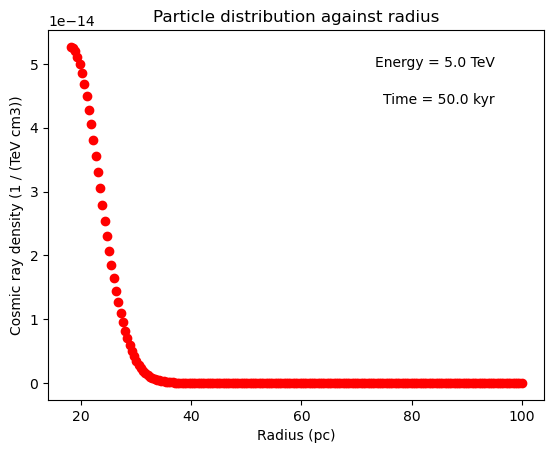

In [8]:
Rs = np.linspace(Rshell(E_input), 100*u.pc, 200)

for R in Rs:
    plt.plot(R, distribution([E_input]*u.TeV, R, T_input), 'ro')

plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution([E_input]*u.TeV, R, T_input).unit})")
plt.text(0.9, 0.9, f"Energy = {E_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Time = {T_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius")


Plotting against t

C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Particle distribution against time')

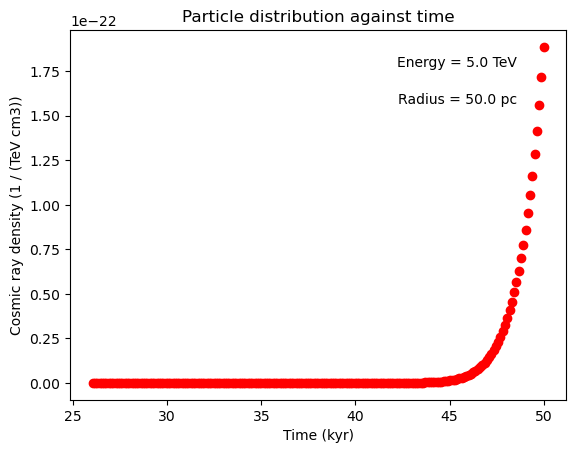

In [9]:
ts = np.linspace(Tesc(E_input).to(u.kyr).value, (50*u.kyr).to(u.kyr).value, 200)*u.kyr

for T in ts:
    plt.plot(T, distribution([E_input]*u.TeV, R_input, T), 'ro')

plt.xlabel(f"Time ({ts.unit})")
plt.ylabel(f"Cosmic ray density ({distribution([E_input]*u.TeV, R_input, T).unit})")
plt.text(0.9, 0.9, f"Energy = {E_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against time")


#plt.yscale("log")

Plotting against E

In [10]:
Es = np.logspace(0, 10, 200)*u.TeV

plt.plot(Es, distribution(Es, R_input, T_input), 'ro')
plt.yscale("log")
plt.xscale("log")

plt.xlabel(f"log(energy) (log{ts.unit})")
plt.ylabel(f"log Cosmic ray density (log{distribution([E_input]*u.TeV, R_input, T).unit})")
plt.text(0.9, 0.9, f"Time = {T_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Any further plots can be made below for hard coded t, R and E. Existing linspaces of ts, Rs and logspace Es can be used, or new ones made

In [46]:
a = np.linspace(1, 10)
mask = a > 5
a[mask]

array([ 5.04081633,  5.2244898 ,  5.40816327,  5.59183673,  5.7755102 ,
        5.95918367,  6.14285714,  6.32653061,  6.51020408,  6.69387755,
        6.87755102,  7.06122449,  7.24489796,  7.42857143,  7.6122449 ,
        7.79591837,  7.97959184,  8.16326531,  8.34693878,  8.53061224,
        8.71428571,  8.89795918,  9.08163265,  9.26530612,  9.44897959,
        9.63265306,  9.81632653, 10.        ])